## 一、贝叶斯优化举例

In [1]:
%matplotlib inline

from bayes_opt import BayesianOptimization
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

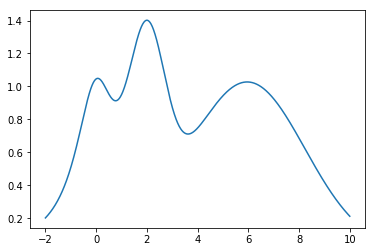

In [3]:
x = np.linspace(-2, 10, 1000).reshape(-1, 1)
y = target(x)

plt.plot(x, y)

In [4]:
bo = BayesianOptimization(target, {'x': (-2, 10)})
bo.maximize(init_points=2, n_iter=0, acq='ucb', kappa=5)
def posterior(bo, x, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(x, return_std=True)
    return mu, sigma

def plot_gp(bo, x, y):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(bo, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(bo.X.flatten(), bo.Y, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = bo.util.utility(x, bo.gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |    0.87819 |   -0.4058 | 
    2 | 00m00s |    1.02030 |    6.2213 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 


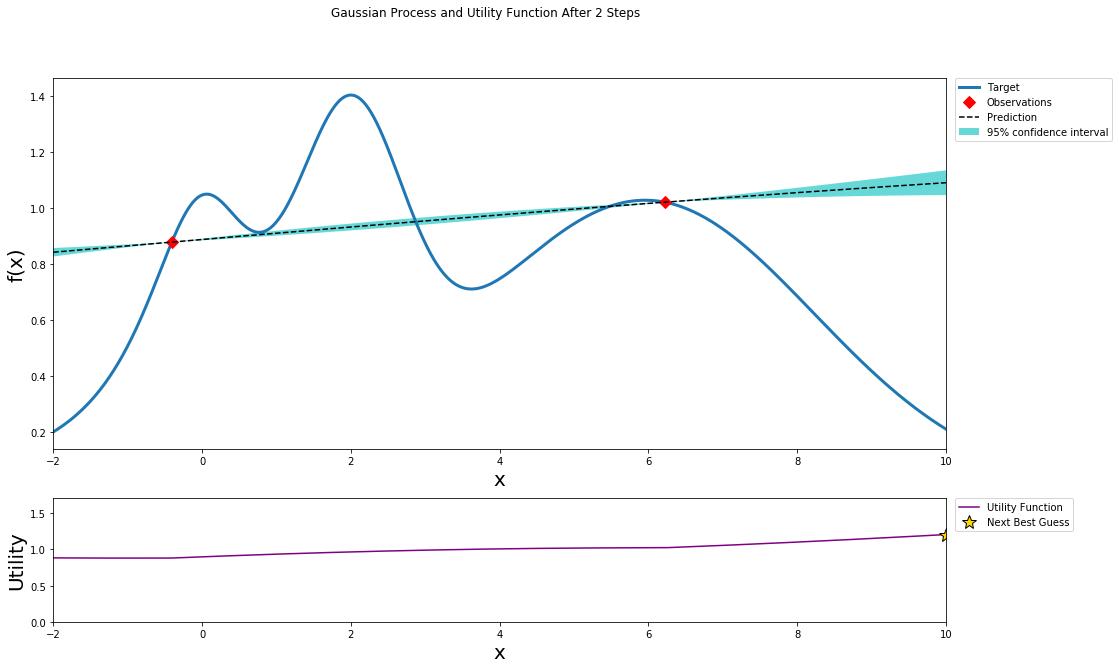

In [5]:
plot_gp(bo, x, y)

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    3 | 00m00s |    0.21180 |   10.0000 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    4 | 00m00s |    0.94951 |    2.8751 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    5 | 00m00s |    0.20166 |   -2.0000 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    6 | 00m00s |    0.87928 |    4.6539 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    7 | 00m00s |    1.03296 |    1.1924 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    8 | 00m01s |    0.71461 |    7.8931 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |       

/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
   17 | 00m03s |    1.40186 |    1.9939 | 


/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.68545404e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


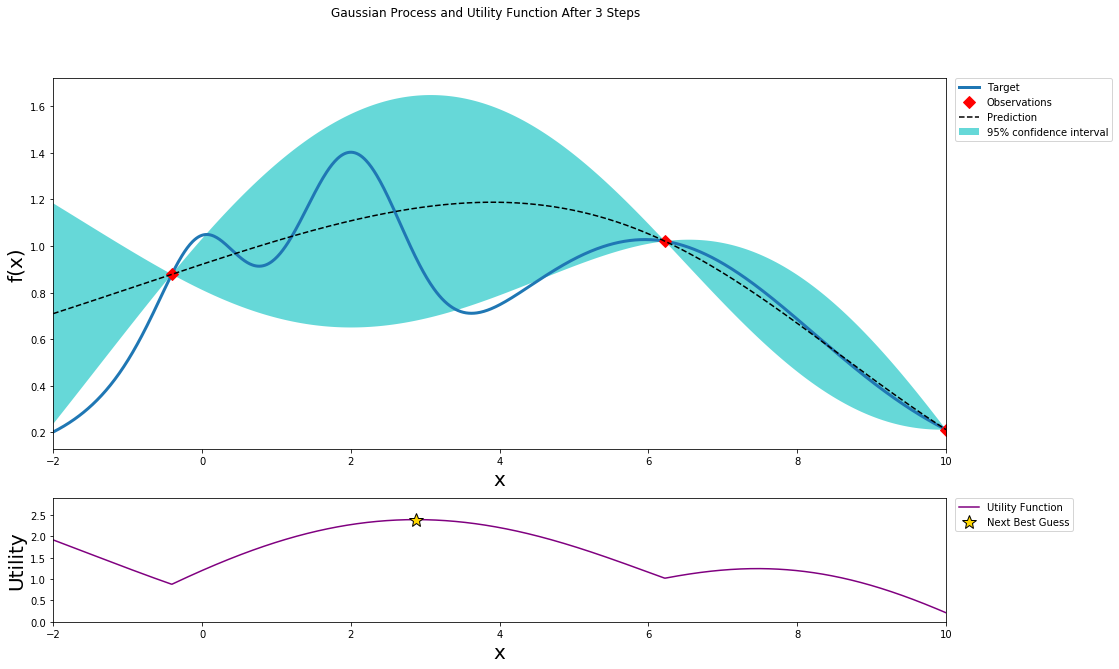

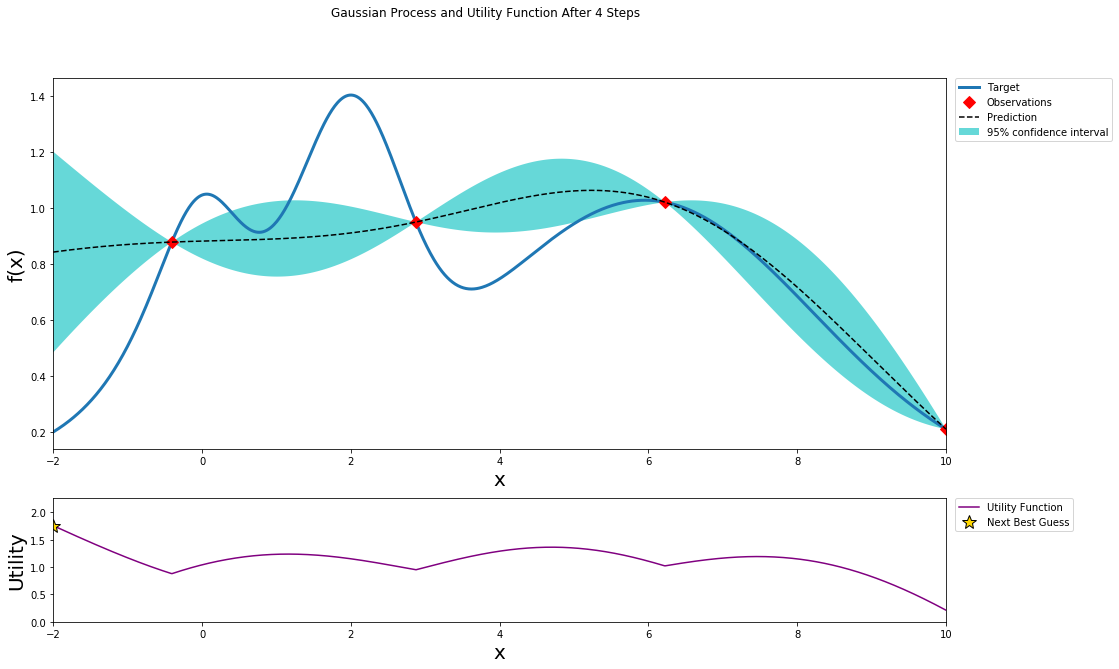

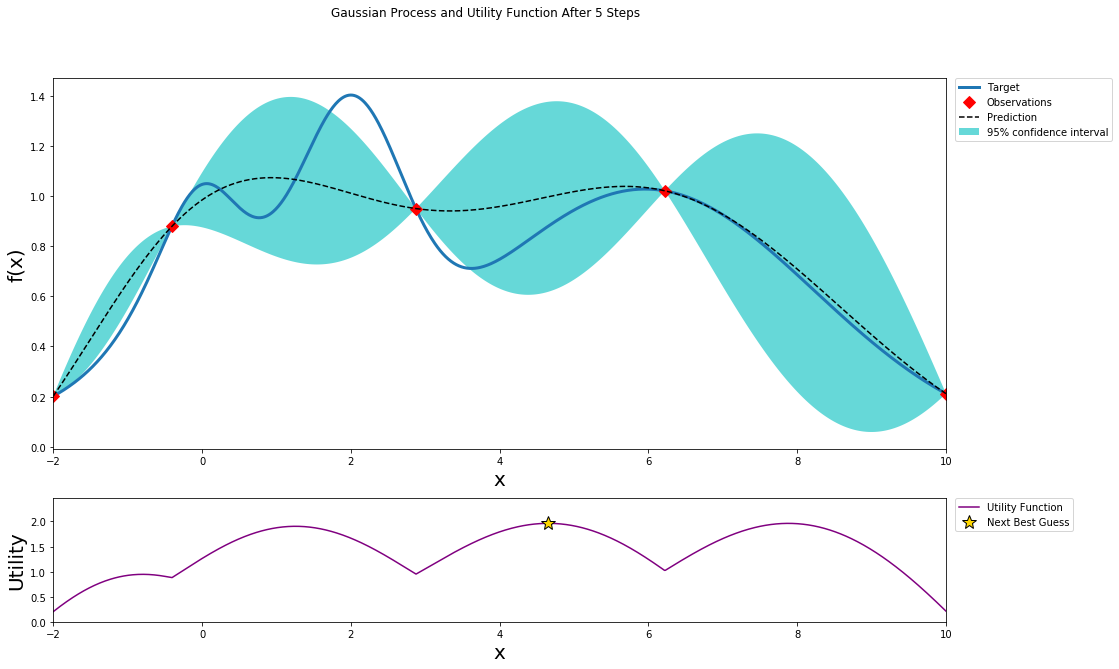

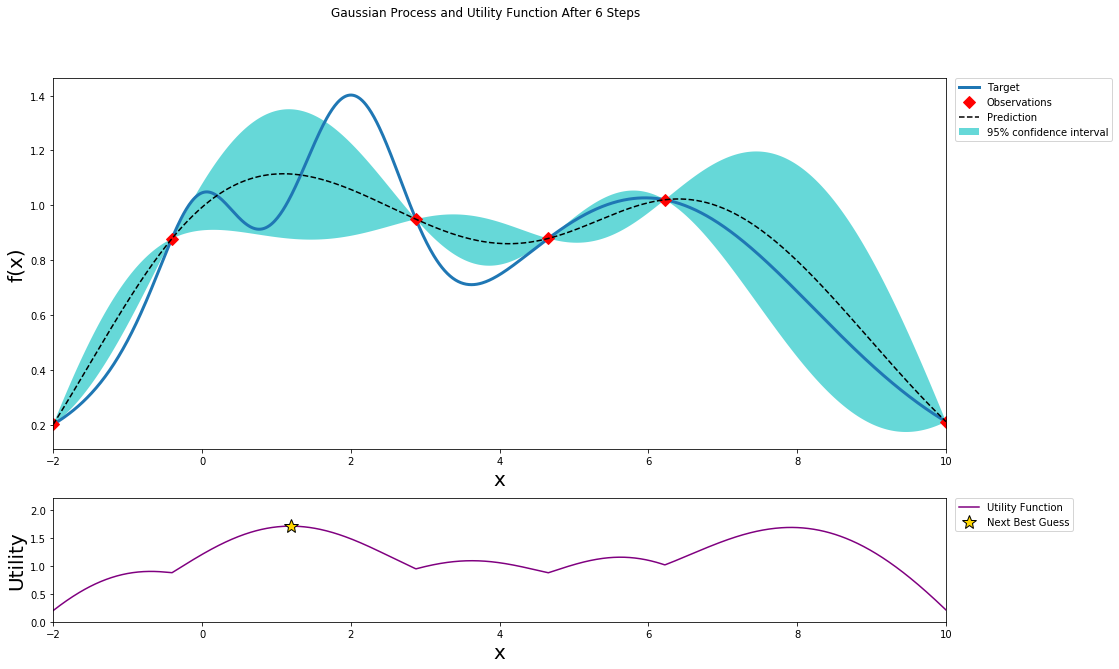

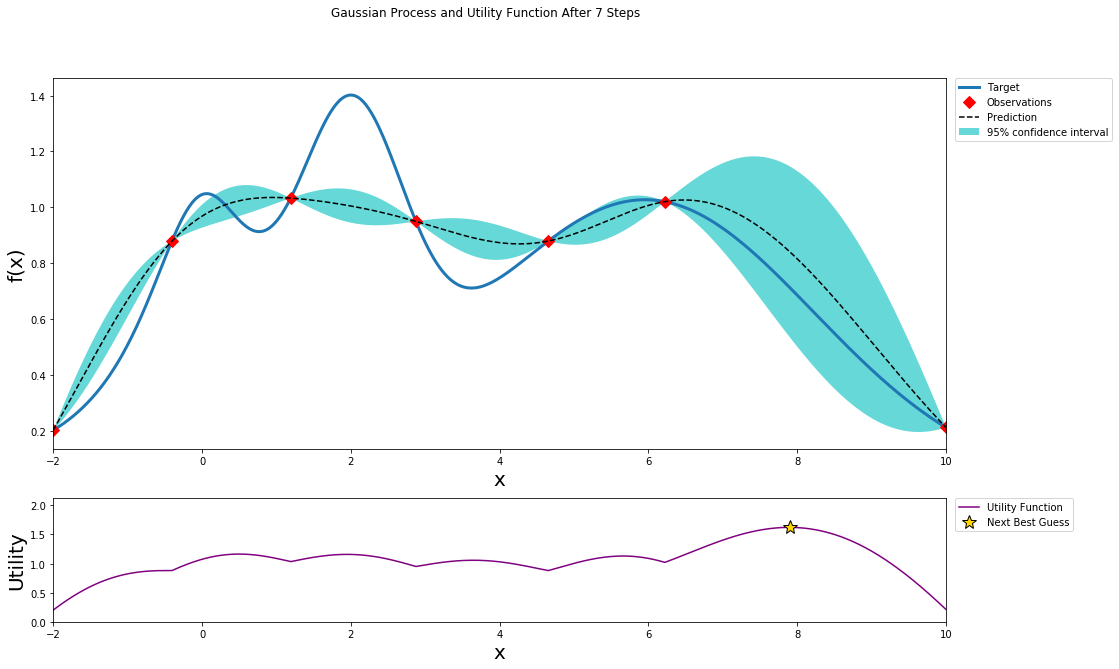

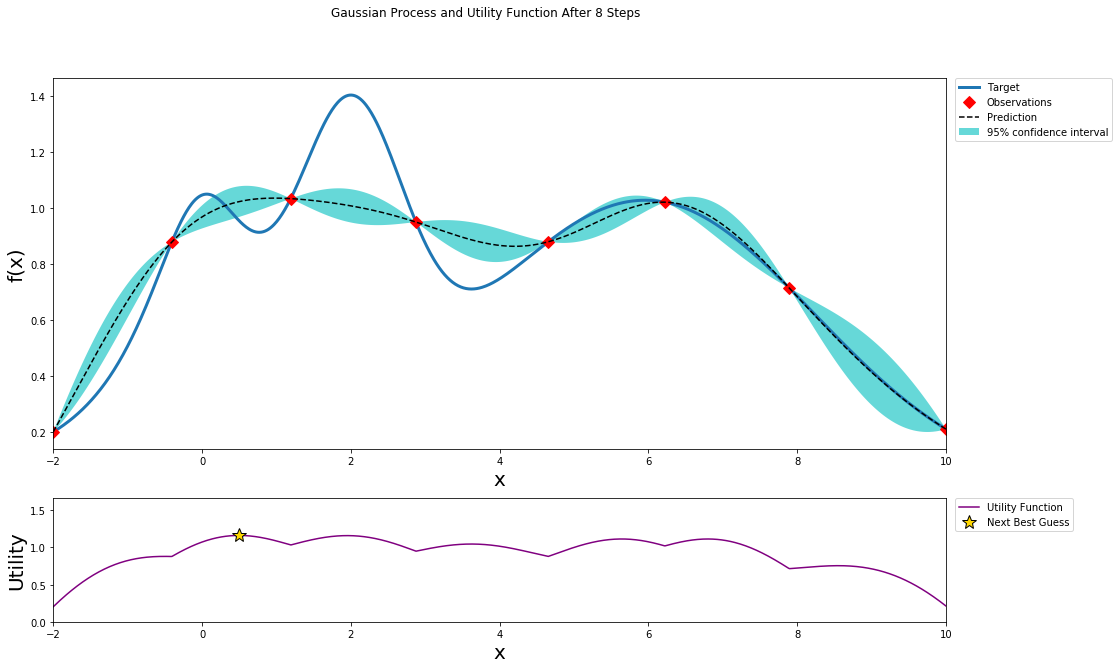

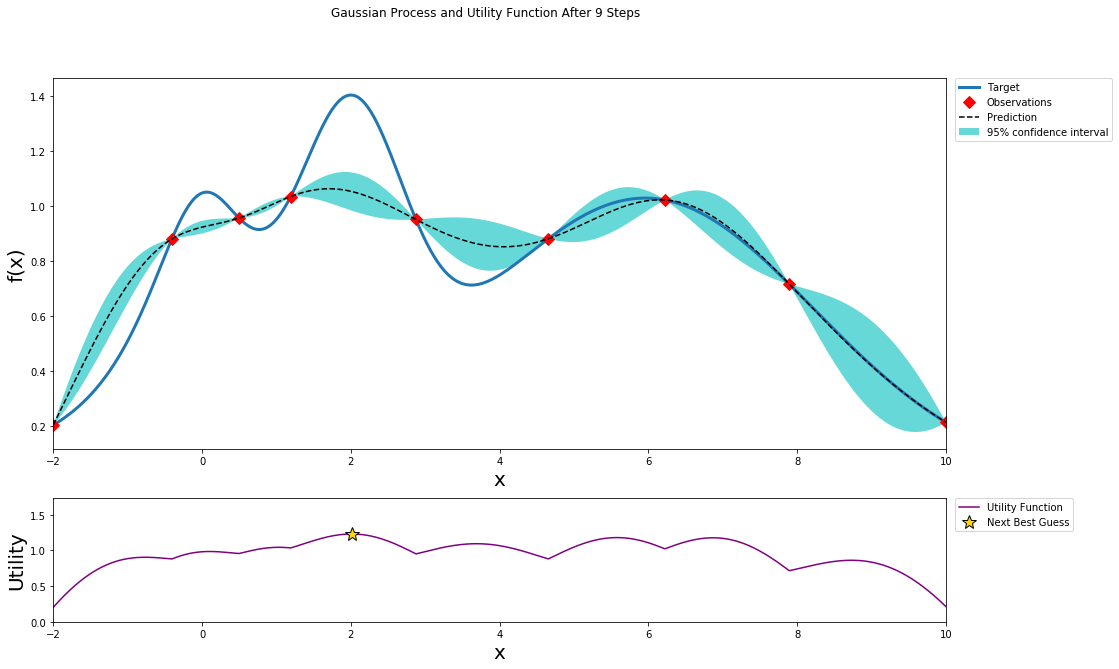

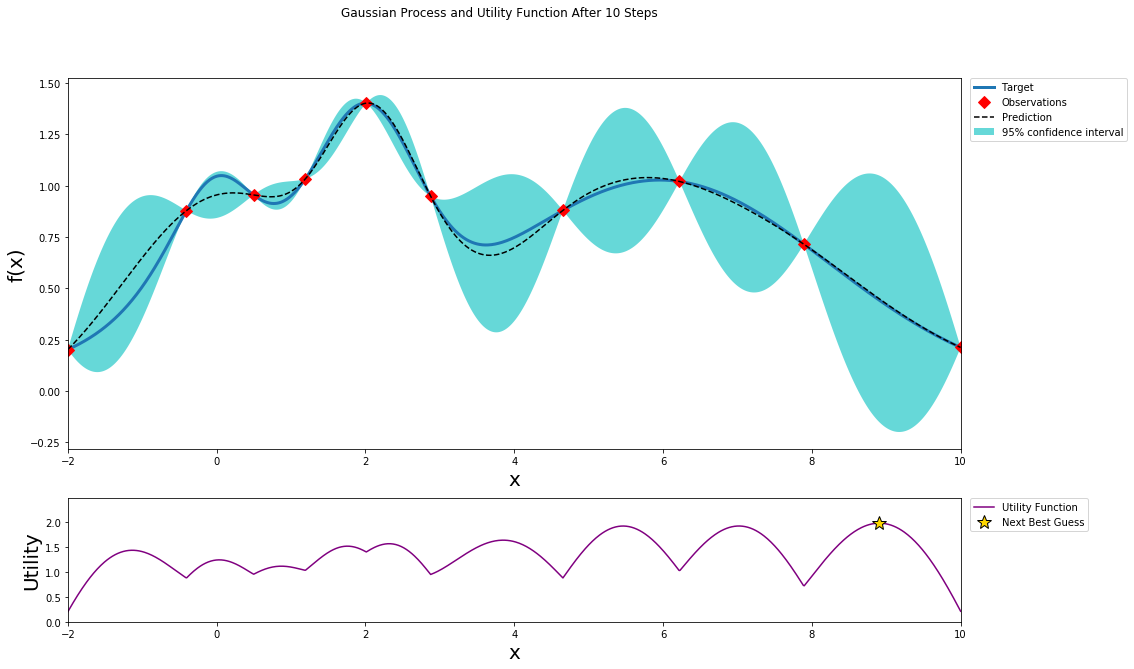

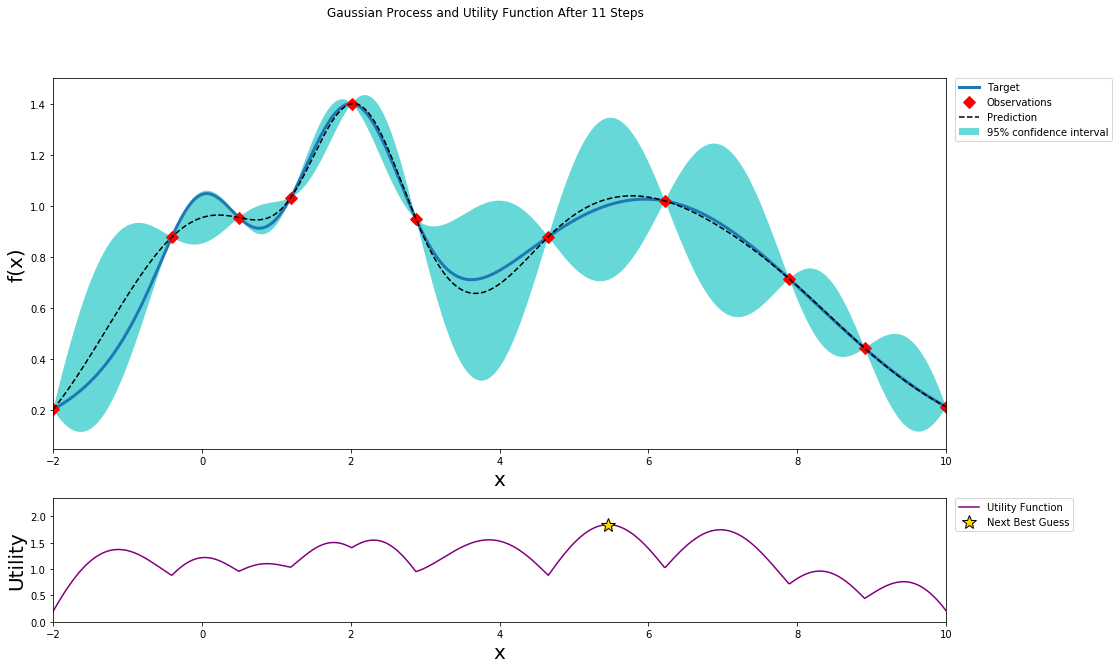

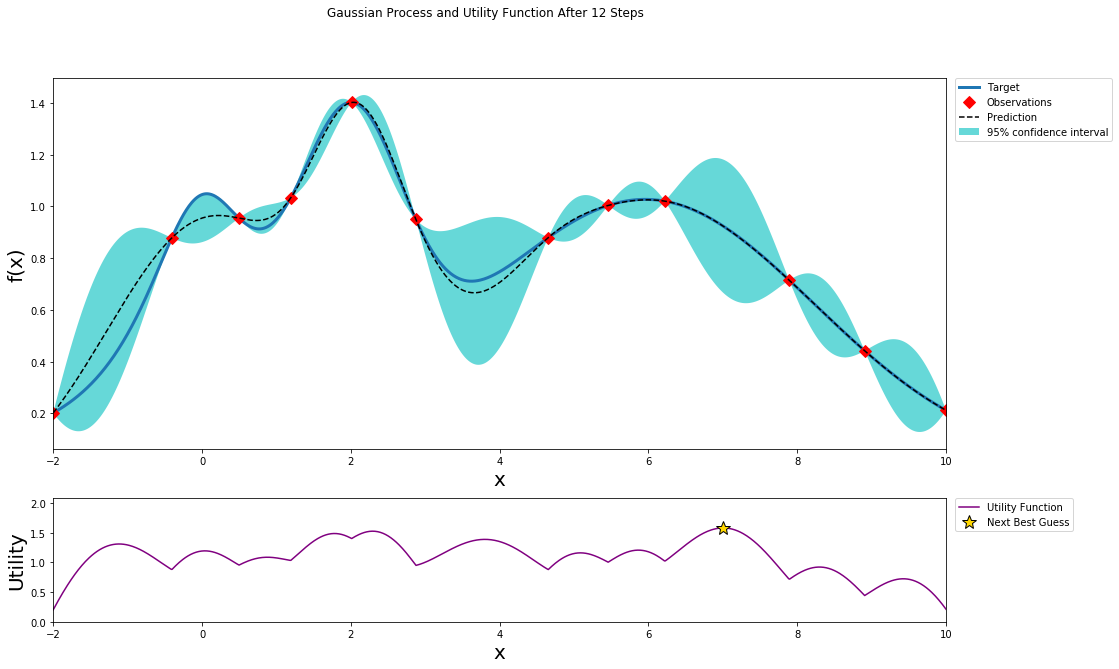

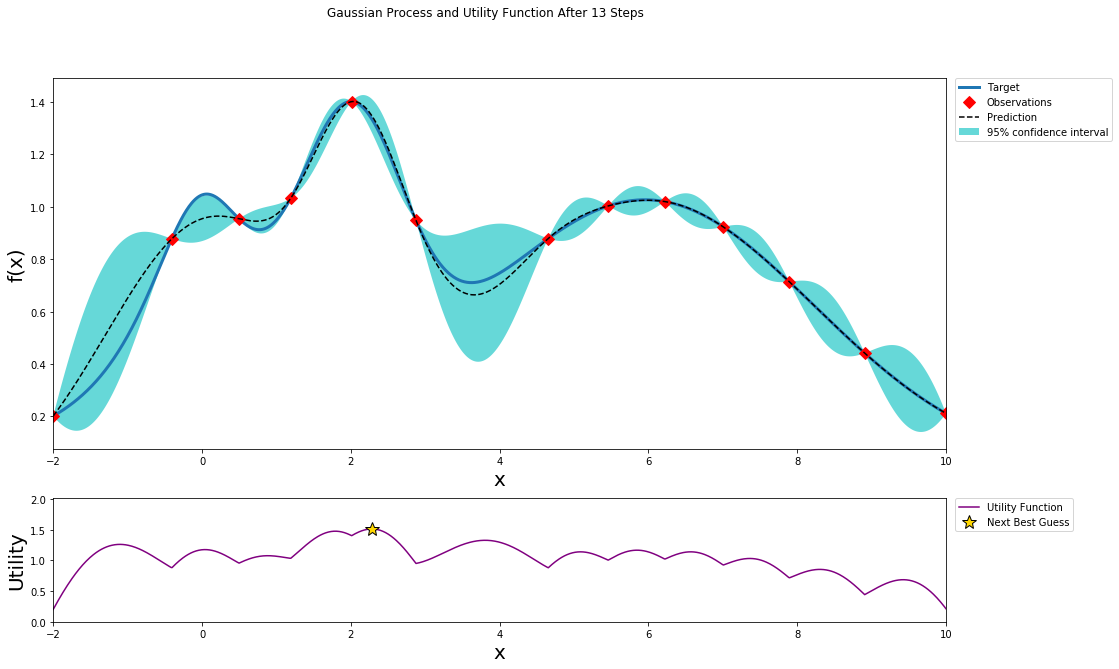

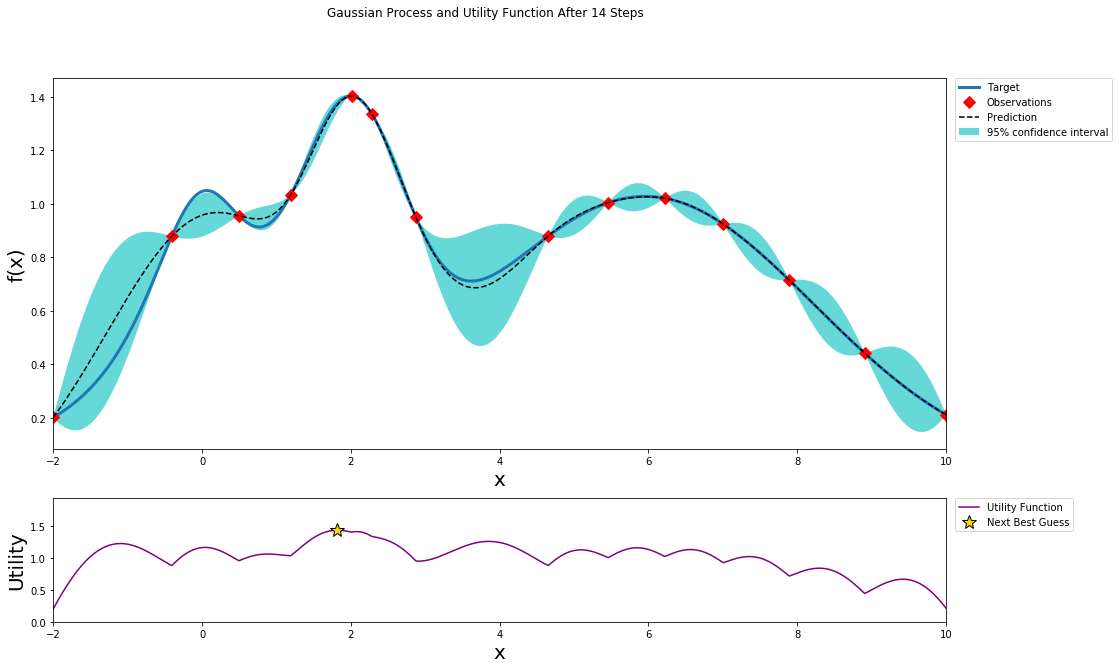

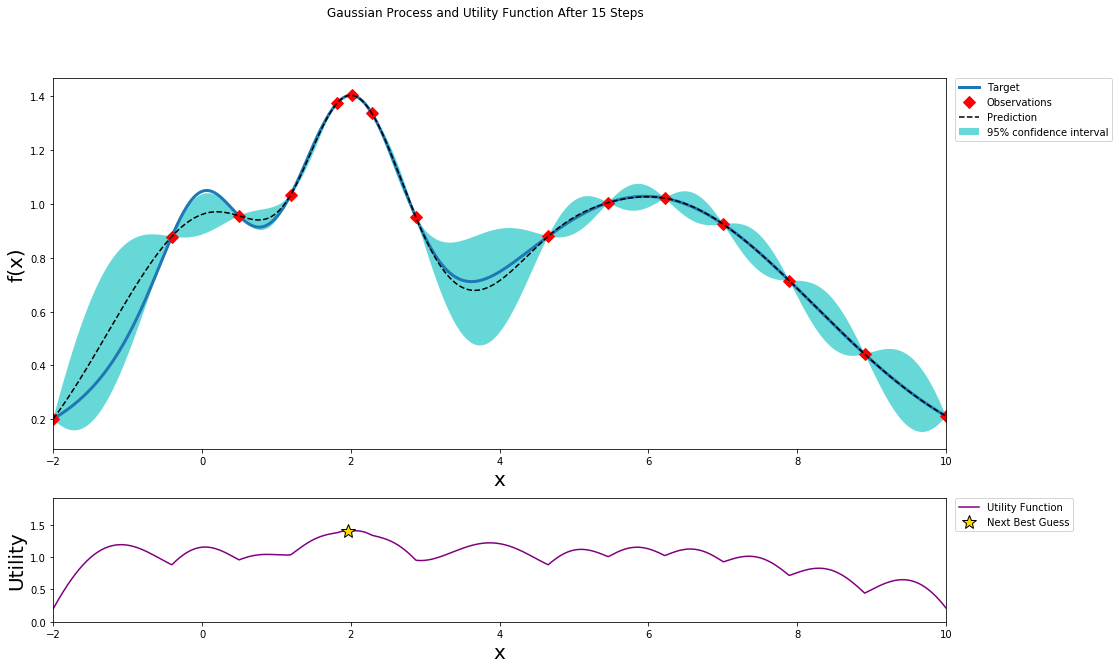

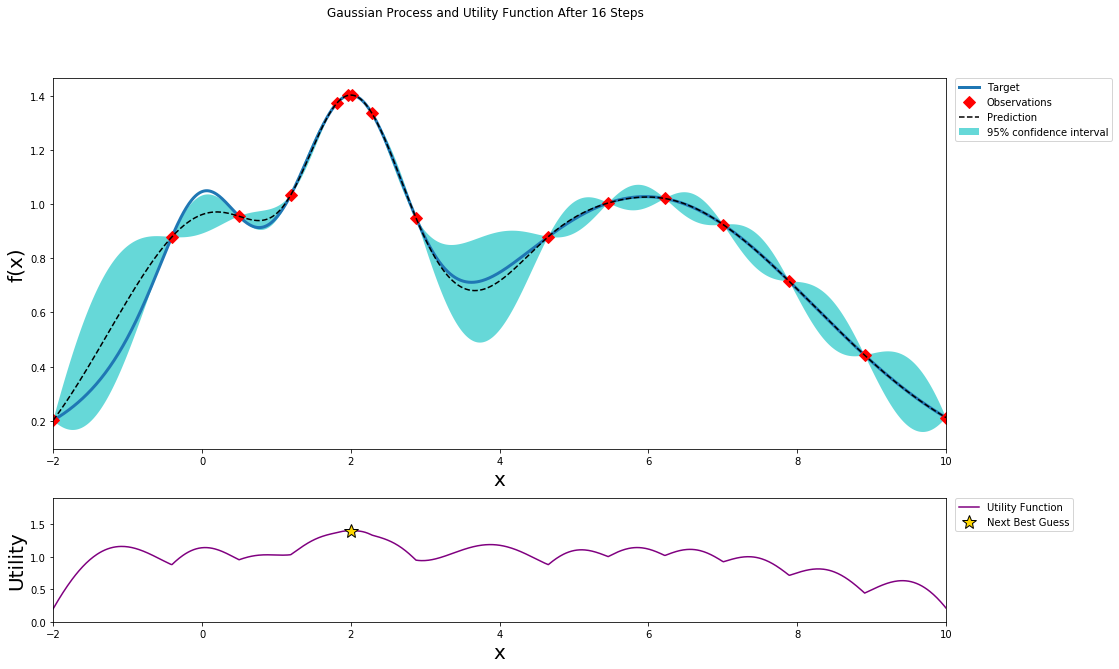

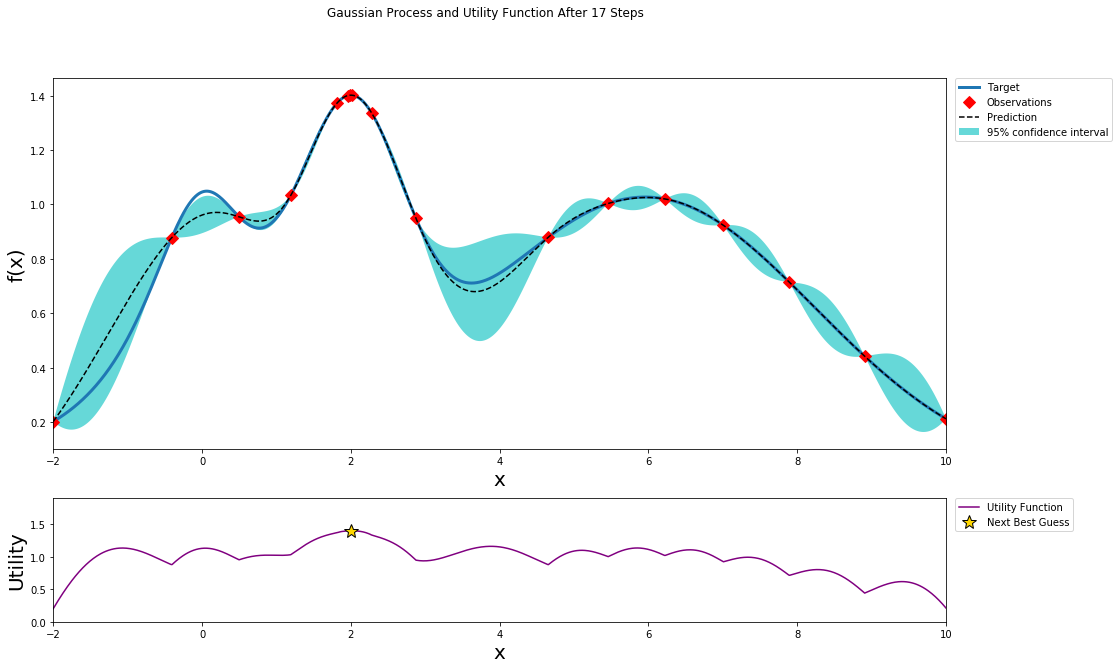

In [6]:
for i in range(15):
    bo.maximize(init_points=0, n_iter=1, kappa=5)
    plot_gp(bo, x, y)

## 二、高斯过程回归理论基础 (GPR)

### 2.1 从随机变量到随机向量
2.1.1. 随机变量 $X$ 是定义在概率空间 $(\Omega,F,P)$ 上的映射。     
即 $X:(\Sigma{\rightarrow}R),R\in[-\infty,+\infty]$ 其中，  
$\omega:$ 样本  
$\Omega:$ 样本空间  
$\Sigma:$ 事件 $\Sigma=\{\omega|\omega\in\Omega\}$     
$F:$ 事件集合 $F=\{\Sigma|\Sigma\subset\Omega\}$，满足$\sigma$代数  
$P:$ 事件发生概率 $P:(F{\rightarrow}R),R\in[0,1]$  
 
2.1.2. 考虑概率空间集合 $\{(\Omega^t,F,P^t)|t\in{T}\}$ 则 $\vec{X}=[X^1, X^2 ... X^t]$ 是随机向量。

### 2.2 随机过程和联合分布
2.2.1. 根据 2.1.2 存在一个函数 $F(\vec{X},\vec{T})=P(\vec{X};\vec{T})$ 可表示随机过程。  
2.2.2. $P(\vec{X}|\vec{T})$ 表示联合概率密度。  
2.2.3. $F(t|\vec{X})$ 就是关于 $t$ 的函数。

### 2.3 联合高斯分布和高斯过程
根据 2.2.1、2.2.2 如果 $P(X^1 ... X^t|\vec{T}) \sim N(\mu^t, \Sigma)$ 满足联合高斯分布，则 $F(\vec{X},\vec{T})$ 表示高斯过程 $GP$。

### 2.4 理解多维高斯分布
2.4.1. 一维:   
$$N(x|\mu,\sigma^2)=\frac{1}{\sqrt{2\pi \sigma^2}}exp(-\frac{1}{2\sigma^2}(x-\mu)^2)，\sigma^2 是方差$$  

2.4.2. 二维:  
![avatar](https://wikimedia.org/api/rest_v1/media/math/render/svg/c6fc534bfde62d6d2b3b743b0c3fa2fb7fc3174a)  
$$\sim N(X,Y|\mu_X, \mu_Y, \sigma_X, \sigma_Y, \rho)$$  

2.4.3. 多维：
![avatar](https://wikimedia.org/api/rest_v1/media/math/render/svg/999bd54845bdbed1807db7d4ead36499c0bdd0d8)  
$$\sim N(\vec{X}|\vec\mu,\Sigma)$$  
$\vec\mu=\begin{bmatrix}{\mu_1}\\{\vdots}\\{\mu_t}\end{bmatrix}$,
$\Sigma=\begin{bmatrix}{\rho\sigma_1\sigma_1}&{\rho\sigma_1\sigma_2}&{\cdots}&{\rho\sigma_1\sigma_t}\\
{\rho\sigma_2\sigma_1}&{\rho\sigma_2\sigma_2}&{\cdots}&{\rho\sigma_2\sigma_t}\\
{\vdots}&{\vdots}&{\ddots}&{\vdots}\\
{\rho\sigma_t\sigma_1}&{\rho\sigma_t\sigma_2}&{\cdots}&{\rho\sigma_t\sigma_t}\\
\end{bmatrix}$ 是相关系数矩阵，其中 $corr(x, y)=\frac{cov(x,y)}{\sigma_x\sigma_y}=\rho\sigma_x\sigma_y$ 为随机变量X，Y的相关系数，$\sigma_x=\sqrt{var(X)}$

$\rho=1$ 表示两个随机变量完全正相关，$\rho=0$ 表示两个随机变量相互独立。

2.4.4. Mercer定理：
任何半正定的函数都可以作为核函数。  
所谓半正定的函数f(xi,xj)，是指拥有训练数据集合（x1,x2,...xn)，我们定义一个矩阵的元素aij = f(xi,xj)，这个矩阵式n*n的，如果这个矩阵是半正定的，那么f(xi,xj)就称为半正定的函数。
这是选择高斯核做为相关系数理论依据。

### 2.5 GPR假设
2.5.1. 假设目标函数 $F$ 属于一个GP，说明 $F$ 服从一个无穷维联合正态分布。因此可以直接通过联合分布求出边沿分布。  
2.5.2. 假设目标函数 $F$ 平滑，说明如果两个 $X$ 离得比较近，那么对应的 $Y$ 值的相关性也就较高。因此协方差矩阵是 $X_i-X_j$ 的函数。